# Example: Continuous Diffusion for Mixed-Type Tabular Data on the adult dataset

Below, we briefly showcase the application of our CDTD model to the adult dataset. This repository simplifies the use of CDTD in practice by providing a wrapper around the training and sampling processes. Note that the hyperparameter choices for the score model differ slightly from those in the paper. In the paper, we ensure that all benchmark models have roughly the same parameters on the adult dataset.

Note that to increase training and sampling speed further, you could use `torch.compile` or, if you have access to a capable GPU, the TensorFloat32 type via `torch.set_float32_matmul_precision('high')`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.preprocessing import OrdinalEncoder, QuantileTransformer, StandardScaler

from cdtd import CDTD

torch.set_float32_matmul_precision("high") # use TF32, comment out if necessary

In [2]:
df = pd.read_csv("data/adult.csv")

cat_features = [
    "income",
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "native-country",
]
cont_features = [feat for feat in df.columns if feat not in cat_features]

# specify integer-valued continuous features (to be rounded after generation)
int_features = ["fnlwgt", "capital-gain", "capital-loss", "age", "educational-num", "hours-per-week"]

# code missings
df = df.replace(r" ", np.nan)
df = df.replace(r"?", np.nan)
df = df.replace(r"", np.nan)

# remove rows with missings in targets
idx_target_nan = df["income"].isna().to_numpy().nonzero()[0]
df.drop(labels=idx_target_nan, axis=0, inplace=True)

# for categorical features, replace missings with 'empty
df[cat_features] = df[cat_features].fillna("empty")

# # for continuous data, drop missings
df.dropna(inplace=True)

# # ensure correct types
X_cat = df[cat_features].to_numpy().astype("str")
X_cont = df[cont_features].to_numpy().astype("float")

# # preprocess categorical classes and convert to integers
cat_int_enc = OrdinalEncoder()
X_cat_enc = cat_int_enc.fit_transform(X_cat)

# # preprocess continuous features using quantile transformation
cont_enc = QuantileTransformer(
    output_distribution="normal",
    n_quantiles=max(min(X_cont.shape[0] // 30, 1000), 10),
    subsample=int(1e9),
    random_state=42,
)
X_cont_enc = cont_enc.fit_transform(X_cont)
cont_std = StandardScaler()
X_cont_enc_std = cont_std.fit_transform(X_cont_enc)

# ensure correct formats
X_cat_train = torch.tensor(X_cat_enc).long()
X_cont_train = torch.tensor(X_cont_enc_std).float()

In [3]:
# initialize and train model
cdtd = CDTD(
    X_cat_train,
    X_cont_train,
)
cdtd.fit(X_cat_train, X_cont_train, num_steps_train=20_000, num_steps_warmup=1000)

Loss (last 100 steps): 2.014: 100%|██████████| 20000/20000 [09:48<00:00, 34.00it/s]

Training took 9.80 min.


MixedTypeDiffusion(
  (model): MLP(
    (time_emb): TimeStepEmbedding(
      (fc): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): SiLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (fc): Sequential(
      (0): Linear(in_features=256, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): ReLU()
      (4): Linear(in_features=1024, out_features=1024, bias=True)
      (5): ReLU()
      (6): Linear(in_features=1024, out_features=1024, bias=True)
      (7): ReLU()
      (8): Linear(in_features=1024, out_features=1024, bias=True)
      (9): ReLU()
    )
    (proj): Linear(in_features=150, out_features=256, bias=True)
    (final_layer): FinalLayer(
      (linear): Linear(in_features=1024, out_features=110, bias=True)
    )
  )
  (cat_enc): CatEmbedding(
    (cat_emb): Embedding(104, 16)
  )
  (weight_network): WeightNetwork(
    (fourier): F

In [4]:
# sample data
X_cat_gen, X_cont_gen = cdtd.sample(num_samples=X_cat_train.shape[0])

# post-process data
X_cat_gen = cat_int_enc.inverse_transform(X_cat_gen)
X_cont_gen = cont_std.inverse_transform(X_cont_gen)
X_cont_gen = cont_enc.inverse_transform(X_cont_gen)

# combine to synthetic dataset
df_gen = pd.concat((pd.DataFrame(X_cat_gen), pd.DataFrame(X_cont_gen)), axis=1)
df_gen.columns = cat_features + cont_features

# round integer features
df_gen[int_features] = df_gen[int_features].round().astype("int")

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:16<00:00,  1.38s/it]


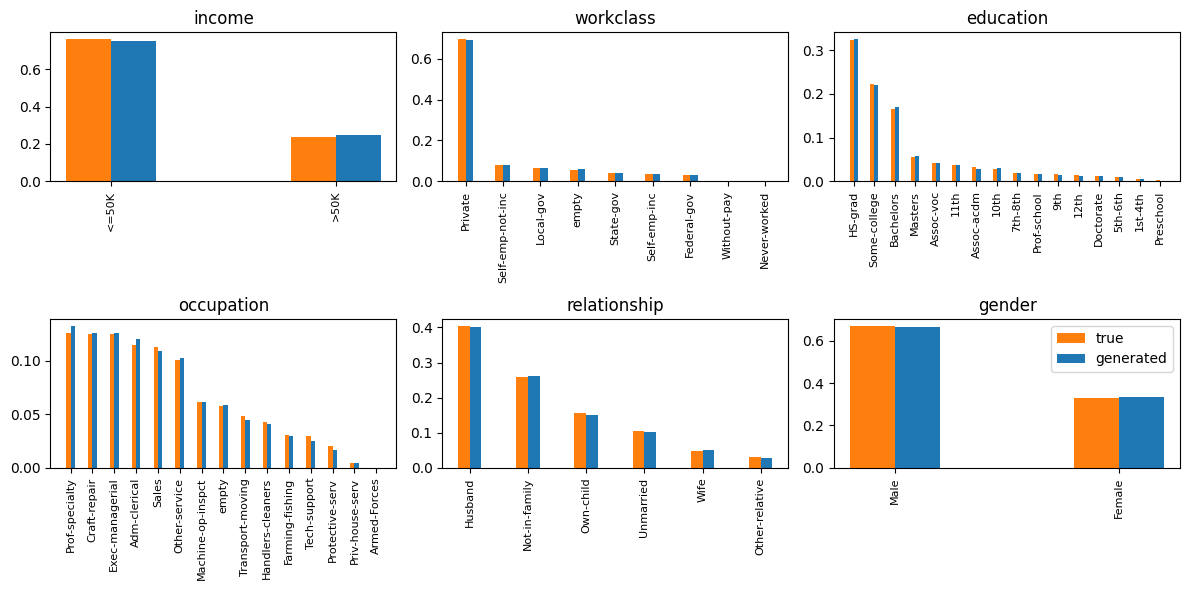

In [5]:
# some functions to simplify plotting

def plot_cat_dist(df_true, df_gen, label, ax):
    counts_true = pd.DataFrame(df_true[label]).value_counts()
    props_true = counts_true / sum(counts_true)
    counts_gen = pd.DataFrame(df_gen[label]).value_counts()
    props_gen = counts_gen / sum(counts_gen)

    # account for categories possibly missed by model
    x = []
    y_true_list = []
    y_gen_list = []

    for cat in props_true.keys():
        x.append(cat[0])
        y_true_list.append(props_true[cat])
        if cat in props_gen.keys():
            y_gen_list.append(props_gen[cat])
        else:
            y_gen_list.append(0.0)

    ax.bar(
        np.arange(len(x)) - 0.1,
        y_true_list,
        color="tab:orange",
        width=0.2,
        label="true",
    )
    ax.bar(
        np.arange(len(x)) + 0.1,
        y_gen_list,
        color="tab:blue",
        width=0.2,
        label="generated",
    )
    ax.set_title(label)
    ax.set_xticks(np.arange(len(x)), x)
    ax.set_xticklabels(x, rotation=90, ha='center', fontsize=8)

    return fig

def plot_cont_dist(df_true, df_gen, label, ax):
    sns.kdeplot(df_true[label], ax=ax, color="tab:orange")
    sns.kdeplot(df_gen[label], ax=ax, color="tab:blue")
    plt.legend(["true", "generated"])
    return fig


# plot categorical data
labels = ["income", "workclass", "education", "occupation", "relationship", "gender"]

fig, ax = plt.subplots(2, 3, figsize=(12, 6))
for i, a in enumerate(ax.flatten()):
    plot_cat_dist(df, df_gen, labels[i], ax=a)
fig.tight_layout(h_pad=1, w_pad=0.4)
plt.legend(["true", "generated"])

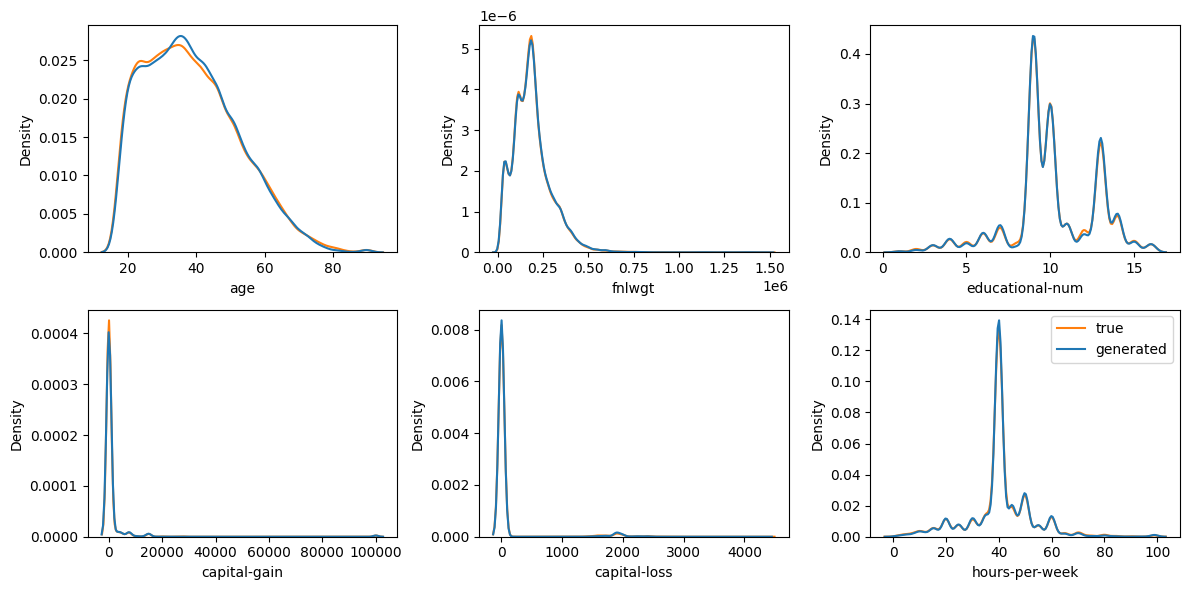

In [6]:
# plot continuous data
labels = cont_features
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
for i, a in enumerate(ax.flatten()):
    plot_cont_dist(df, df_gen, labels[i], ax=a)
fig.tight_layout(h_pad=1, w_pad=0.4)